# TSSL Lab 1 - Autoregressive models

### Name: Mohamed Ali - mohal954
### Group Number: 20

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as pl
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model
from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF
#Importing pyplot module
import matplotlib.pyplot as plt

import statsmodels.api as sm

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

In [2]:
#Reading our data set
df=pandas.read_csv("sealevel.csv")

We now visualize our dataset in two dimensions, with the X-axis representing the years and the Y-axis depicting the Global Mean Sea Level (GMSL).

Text(0.5, 1.0, 'Global Mean Sea Level')

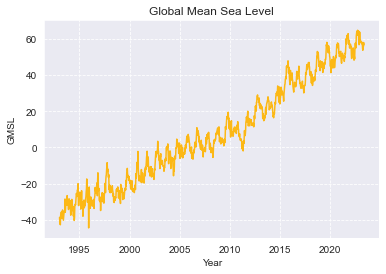

In [3]:
plt.plot('Year','GMSL',data=df,color='#FCB815')
plt.grid(True, linestyle='--')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Global Mean Sea Level')

The dataset comprises 1,120 raw data points representing the global mean sea level from 1992 to 2023. These data have been aggregated at the row level to calculate the mean for a specific set of observations. In total, there are 502,586,454 observations, which may originate from various locations

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** Removing the trend helps make the data stationary, allowing the AR model to capture the autocorrelation patterns without being confounded by the trend.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

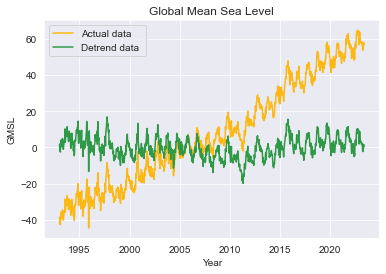

In [4]:
t=df.__array__()[:,2]
t=t.reshape(-1,1)
y=df.__array__()[:,5]
model = lm.LinearRegression().fit(t,y)
trend=model.predict(t)
df_det=y-trend
plt.plot(t,y,color='#FCB815')
plt.plot(t,df_det,color='#2E9947')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Global Mean Sea Level')
plt.legend(('Actual data','Detrend data '))

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

In [5]:
tr_df=df_det[0:700]
va_df=df_det[700:]
len(va_df)

419

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [6]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>


    # Construct the regression matrix
    Phi = np.zeros((n-p,p)) # First we build a martix with n-p+1 and p dimentions
    for j in range(p):
        Phi[:,j] = y[j:n+j-p] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_


In [7]:

theta=fit_ar(tr_df,10)

**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [8]:
def predict_ar_1step(theta, y_target):

    # I have tweked a bit in the function to have te training data se and validation data sent the calculating the theta using the training data set and the do the prediction on the validation data set
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """
    # We specify the prder p and number of samples n
    n = len(y_target)
    p = len(theta)

    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)

    # We start our loop
    for i in range(m):
        # a result vector is specified here to take the samples
        res=y_target[i:p+i]
        # we calculate the value of y_pred as in the slides note
        y_pred[i] = sum(res*theta)
    # now we calculate the residuals by subtracting y_acctual - y_predicted
        
    return y_pred

First We calculate for the Validation data set

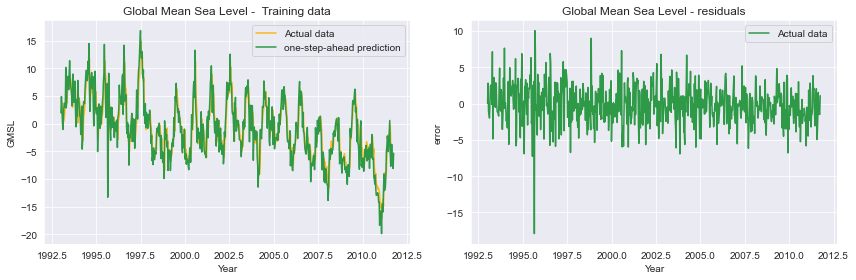

In [9]:
p=len(theta)
y_pred_tr=predict_ar_1step(theta,tr_df)
res_tr= tr_df[10:]-y_pred_tr

# Ploting our prediction and the acctual y
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t[:len(tr_df)-p],y_pred_tr,color='#FCB815')
axes[0].plot(t[:len(tr_df)-p],tr_df[p:],color='#2E9947')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('GMSL')
axes[0].set_title('Global Mean Sea Level -  Training data')
axes[0].legend(('Actual data','one-step-ahead prediction'))

# Now we plot the residuals
axes[1].plot(t[:len(tr_df)-p],res_tr,color='#2E9947')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('error')
axes[1].set_title('Global Mean Sea Level - residuals')
axes[1].legend(('Actual data','Detrend data '))

plt.tight_layout()


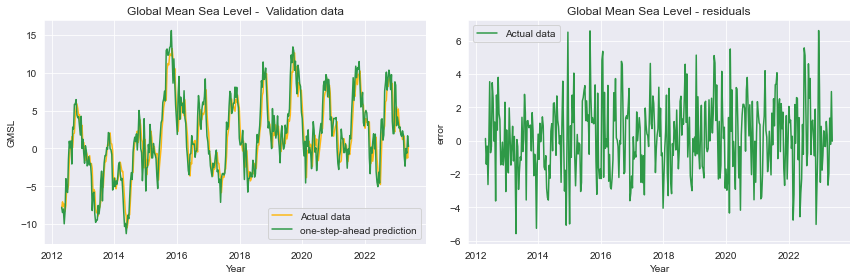

In [10]:
y_pred_va=predict_ar_1step(theta,va_df)
res_va= va_df[10:]-y_pred_va

# Ploting our prediction and the acctual y
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t[len(tr_df)+p:],y_pred_va,color='#FCB815')
axes[0].plot(t[len(tr_df)+p:],va_df[p:],color='#2E9947')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('GMSL')
axes[0].set_title('Global Mean Sea Level -  Validation data')
axes[0].legend(('Actual data','one-step-ahead prediction'))

# Now we plot the residuals
axes[1].plot(t[len(tr_df)+p:],res_va,color='#2E9947')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('error')
axes[1].set_title('Global Mean Sea Level - residuals')
axes[1].legend(('Actual data','Detrend data '))

plt.tight_layout()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

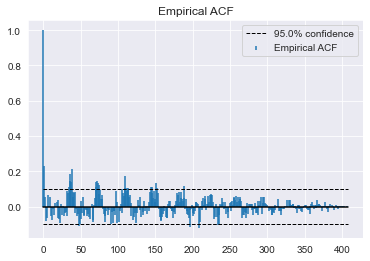

In [11]:
fig1=acfplot(res_va,conf=0.95)

The graph presented above illustrates the Autocorrelation Function (ACF) of the residuals. Along the x-axis, we examine various time lags, while the y-axis represents the correlation coefficients. Typically, at lag 0, a prominent peak is observed due to the correlation of the time series with itself at lag 0.
Examining the overall ACF plot of lags, we observe that beyond approximately lag 30, there may be indications of correlation among the white noise components. This is evident as the majority of coefficient values surpass the Confidence Interval (CI) level.
To delve deeper into this observation, we rerun the code with a specific request for 50 lags, allowing for a more detailed examination of the autocorrelation patterns.

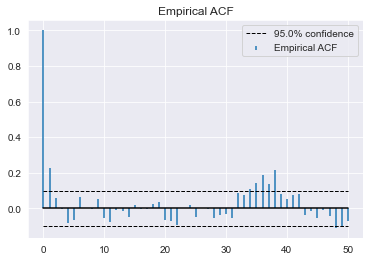

In [12]:
fig1=acfplot(res_va,50,conf=0.95)

Observing the ACF plot, it becomes evident that correlations among the white noise components start to emerge after Lag 30. Conversely, lags preceding 30 suggest the absence of significant correlation within our white noise.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [13]:
mse_tr=[]
mse_va=[]
for i in range(2,150):
# Calculating the MSE for different orders in Training set
    theta=fit_ar(tr_df,i)
    y_pred_tr1=predict_ar_1step(theta,tr_df)
    res1=np.mean((y_pred_tr1-tr_df[i:])**2)
    mse_tr.append(res1)
# Calculating the MSE for different orders in Validation set
    y_pred_va1=predict_ar_1step(theta,va_df)
    res2=np.mean((y_pred_va1-va_df[i:])**2)
    mse_va.append(res2)

Text(0.5, 1.0, 'Training and Validation mean-squared errors')

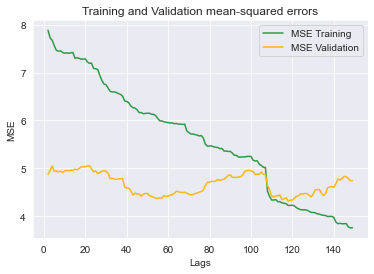

In [14]:
# No we plot the MSE for Both training and Validation set
plt.plot(range(2,150),mse_tr,color='#2E9947')
plt.plot(range(2,150),mse_va,color='#FCB815')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend(('MSE Training','MSE Validation'))
plt.title('Training and Validation mean-squared errors')


Order :  118
MSE :  4.3180592990183495


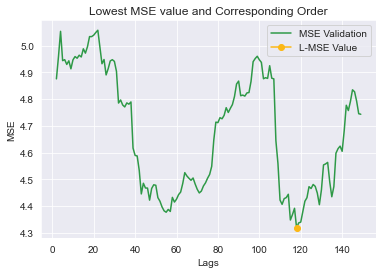

In [15]:
MSE_ord = np.argmin(mse_va)
Order = range(2,150)[MSE_ord]
Value = mse_va[MSE_ord]
plt.plot(range(2,150) ,mse_va,color='#2E9947')
plt.plot(Order, Value, marker='o',color='#FCB815')
plt.xlabel('Lags')
plt.ylabel('MSE')
plt.legend(('MSE Validation','L-MSE Value'))
plt.title('Lowest MSE value and Corresponding Order')
print('Order : ', Order)
print('MSE : ', Value)

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

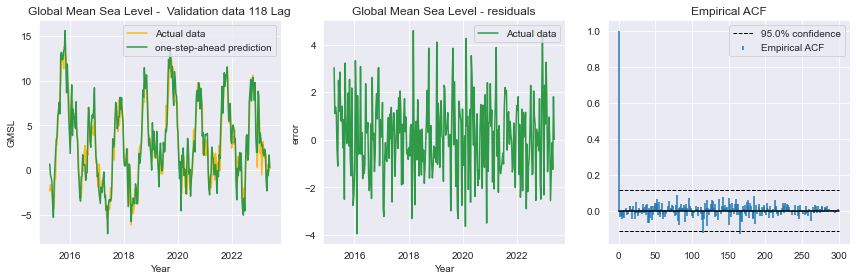

In [16]:
p=Order
theta=fit_ar(va_df,p)
y_pred_va=predict_ar_1step(theta,va_df)
res_va= va_df[p:]-y_pred_va

# Ploting our prediction and the acctual y
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(t[len(tr_df)+p:],y_pred_va,color='#FCB815')
axes[0].plot(t[len(tr_df)+p:],va_df[p:],color='#2E9947')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('GMSL')
axes[0].set_title('Global Mean Sea Level -  Validation data 118 Lag')
axes[0].legend(('Actual data','one-step-ahead prediction'))

# Now we plot the residuals
axes[1].plot(t[len(tr_df)+p:],res_va,color='#2E9947')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('error')
axes[1].set_title('Global Mean Sea Level - residuals')
axes[1].legend(('Actual data','Detrend data '))

fig1=acfplot(res_va,conf=0.95)

plt.tight_layout()

It's evident that the white noise exhibits no significant correlation, as most of the correlation values fall within the bounds of our upper and lower Confidence Interval (CI). There may be isolated exceptions at certain lags.


## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [17]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    # The following loop applies the prediction process to forecast future process steps, i.e., we aim to calculate y_hat for t = n+1, ..., n+m.
    # The concept here is to initially construct our phi values as (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] represents the last training data point.
    # Subsequently, we determine the value of y_t using the coefficients (thetas) * the phi values. This holds for our initial values.
    # Next, we update the phi value by setting phi = y_hat (from the previous step, phi_old_1:p-1). It's as if we move the last element in phi to the beginning and then update it with the y_hat value.
    for i in range(m):
        y_sim[i] = sum(theta*phi)
        phi = np.concatenate((phi[-1:], phi[:-1]))
        phi[0]=y_sim[i]
    
    return y_sim


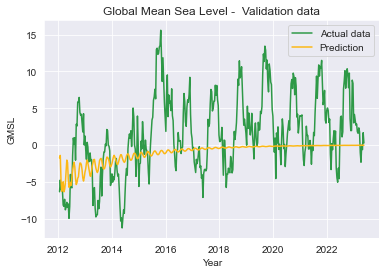

In [18]:
# First we use our training dataset to find the thetas values
theta=fit_ar(tr_df,10)
m=len(tr_df)
y_sim=simulate_ar(tr_df,theta,len(va_df))
plt.plot(t[len(tr_df):],va_df,color='#2E9947')
plt.plot(t[len(tr_df):],y_sim,color='#FCB815')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Global Mean Sea Level -  Validation data')
plt.legend(('Actual data','Prediction'))

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

Text(0.5, 1.0, 'm = 2000 Prediction')

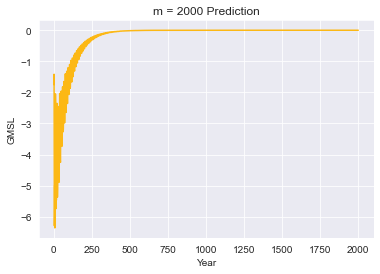

In [19]:
theta=fit_ar(tr_df,10)
m=len(tr_df)
y_sim=simulate_ar(tr_df,theta,2000)
plt.plot(range(len(y_sim)),y_sim,color='#FCB815')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('m = 2000 Prediction')

In an Autoregressive (AR) model with an order of p, employed for forecasting m steps ahead, it's typically not anticipated that the forecasted values will ultimately settle at a constant prediction of zero. The observed behavior in the previous simulation might be influenced by our selection of model order and the presence of noise in the data. However, by conducting multiple simulations using various orders other than 10:

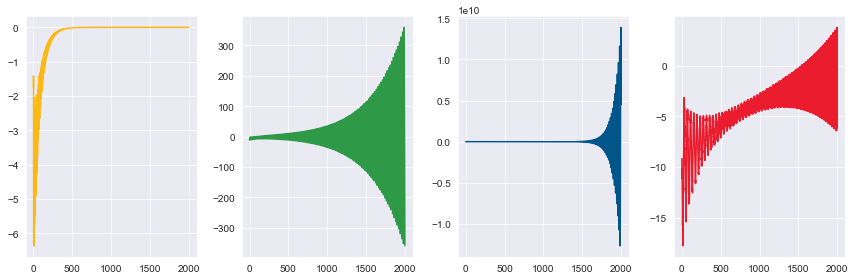

In [20]:
theta10=fit_ar(tr_df,10)
theta20= fit_ar(tr_df,20)
theta30 = fit_ar(tr_df,30)
theta40 = fit_ar(tr_df,40)

y_sim10=simulate_ar(tr_df,theta10,2000)
y_sim20=simulate_ar(tr_df,theta20,2000)
y_sim30=simulate_ar(tr_df,theta30,2000)
y_sim40=simulate_ar(tr_df,theta40,2000)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].plot(range(len(y_sim)),y_sim10,color='#FCB815')
axes[1].plot(range(len(y_sim)),y_sim20,color='#2E9947')
axes[2].plot(range(len(y_sim)),y_sim30,color='#00558B')
axes[3].plot(range(len(y_sim)),y_sim40,color='#EB1C2E')


plt.tight_layout()

**A11:**

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


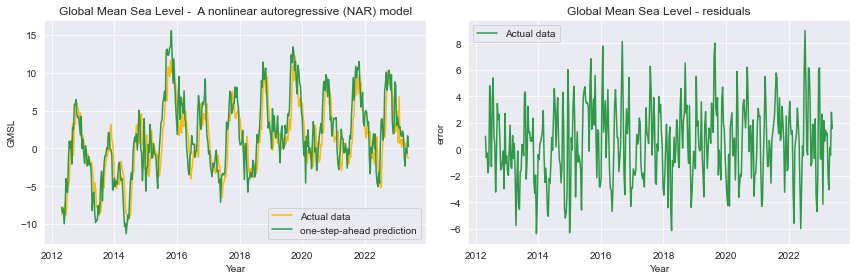

In [21]:

df_tr = tr_df
# 10 here represent the number of the time steps as we can see we have 10 day represent 1 time step, thus we reshape our data to be in 10 steps
df_tr = np.array([df_tr[i:i + 10] for i in range(len(df_tr) - 10)])
X_tr = df_tr[:, :-1]
Y_tr = df_tr[:, -1:]

df_va = va_df
# 10 here represent the number of the time steps as we can see we have 10 day represent 1 time step, thus we reshape our data to be in 10 steps
df_va = np.array([df_va[i:i + 10] for i in range(len(df_va) - 10)])
X_va= df_va[:, :-1]
Y_va = df_va[:, -1:]


regr = MLPRegressor(random_state=1, max_iter=500).fit(X_tr, Y_tr)
y_preds=regr.predict(X_va)
res_va_nn= va_df[10:]-y_preds


# 10 here to skip the first 10 elements as we used the in the y
# Ploting our prediction and the acctual y
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t[len(tr_df)+10:],y_preds,color='#FCB815')
axes[0].plot(t[len(tr_df)+10:],va_df[10:],color='#2E9947')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('GMSL')
axes[0].set_title('Global Mean Sea Level -  A nonlinear autoregressive (NAR) model')
axes[0].legend(('Actual data','one-step-ahead prediction'))

# Now we plot the residuals
axes[1].plot(t[len(tr_df)+10:],res_va_nn,color='#2E9947')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('error')
axes[1].set_title('Global Mean Sea Level - residuals')
axes[1].legend(('Actual data','Detrend data '))

plt.tight_layout()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

Note that:

#### hidden_layer_sizesarray-like of shape(n_layers - 2,), default=(100,)
The ith element represents the number of neurons in the ith hidden layer.
#### activation
*{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’*
Activation function for the hidden layer.
‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x
‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).
‘relu’, the rectified linear unit function, returns f(x) = max(0, x)
#### solver
*{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’*
The solver for weight optimization.
‘lbfgs’ is an optimizer in the family of quasi-Newton methods.
‘sgd’ refers to stochastic gradient descent.
‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.
#### max_iterint, default=200
Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

**A13:**

C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


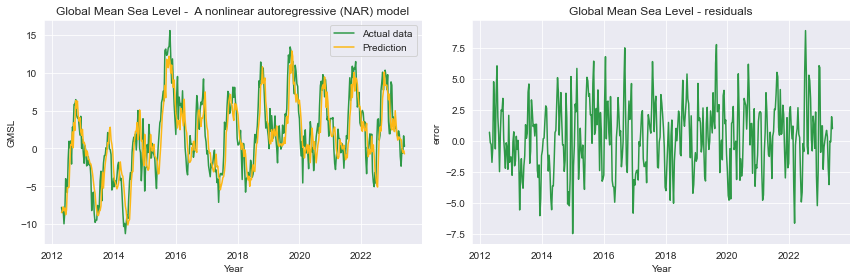

In [22]:



regressor = MLPRegressor(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=500).fit(X_tr, Y_tr)

y_preds=regressor.predict(X_va)
res_va_nn= va_df[10:]-y_preds


# 10 here to skip the first 10 elements as we used the in the y
# Ploting our prediction and the acctual y
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t[len(tr_df)+10:],va_df[10:],color='#2E9947')
axes[0].plot(t[len(tr_df)+10:],y_preds,color='#FCB815')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('GMSL')
axes[0].set_title('Global Mean Sea Level -  A nonlinear autoregressive (NAR) model')
axes[0].legend(('Actual data','Prediction'))

# Now we plot the residuals
axes[1].plot(t[len(tr_df)+10:],res_va_nn,color='#2E9947')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('error')
axes[1].set_title('Global Mean Sea Level - residuals')


plt.tight_layout()

C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_mul

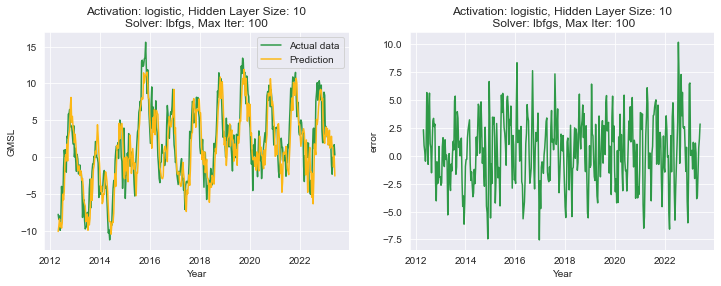

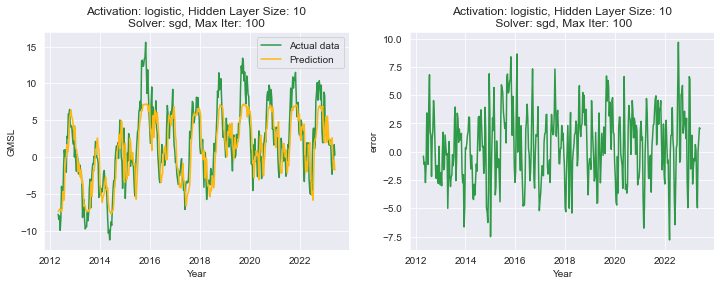

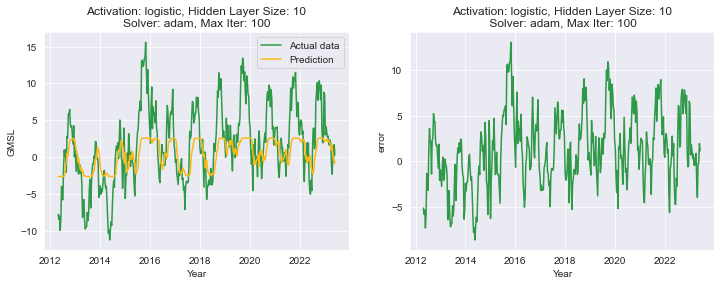

In [23]:

# Define the lists of hyperparameter values to loop through
activations = ['logistic']
hidden_layer_sizes = [10]
solvers = ['lbfgs', 'sgd', 'adam']
max_iters = [100]

# Loop through all combinations
for activation in activations:
    for hidden_size in hidden_layer_sizes:
        for solver in solvers:
            for max_iter in max_iters:
                # Create and fit the MLPRegressor model for the current combination
                regressor = MLPRegressor(
                    hidden_layer_sizes=hidden_size,
                    activation=activation,
                    solver=solver,
                    max_iter=max_iter).fit(X_tr, Y_tr)

                y_preds=regressor.predict(X_va)
                res_va_nn= va_df[10:]-y_preds


                # 10 here to skip the first 10 elements as we used the in the y
                # Ploting our prediction and the acctual y
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))
                axes[0].plot(t[len(tr_df)+10:],va_df[10:],color='#2E9947')
                axes[0].plot(t[len(tr_df)+10:],y_preds,color='#FCB815')
                axes[0].set_xlabel('Year')
                axes[0].set_ylabel('GMSL')
                axes[0].set_title(f"Activation: {activation}, Hidden Layer Size: {hidden_size}\nSolver: {solver}, Max Iter: {max_iter}")
                axes[0].legend(('Actual data','Prediction'))

                # Now we plot the residuals
                axes[1].plot(t[len(tr_df)+10:],res_va_nn,color='#2E9947')
                axes[1].set_xlabel('Year')
                axes[1].set_ylabel('error')
                axes[1].set_title(f"Activation: {activation}, Hidden Layer Size: {hidden_size}\n Solver: {solver}, Max Iter: {max_iter}")

C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\moham\anaconda3\lib\site-packages\sklearn\neural_network\_mul

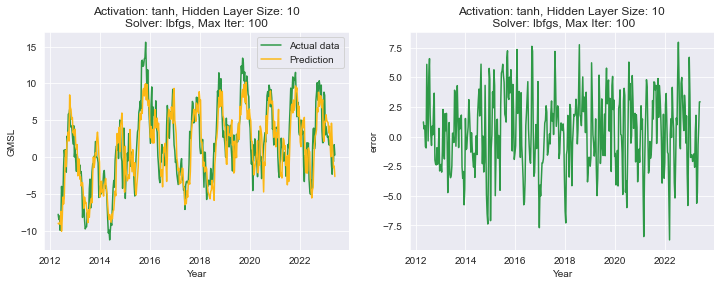

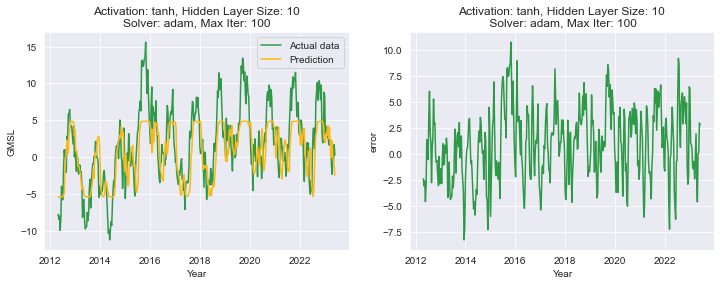

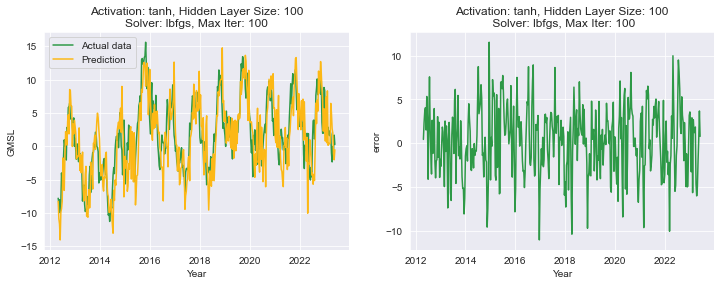

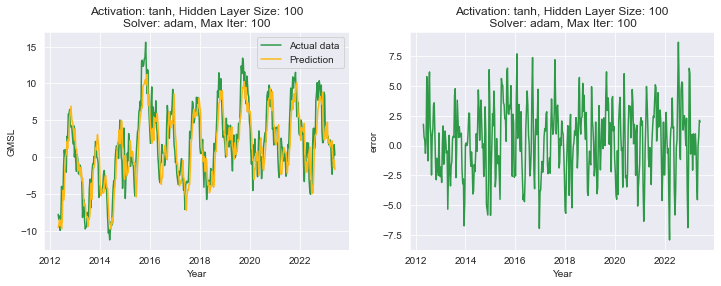

In [24]:
# Define the lists of hyperparameter values to loop through
activations = ['tanh']
hidden_layer_sizes = [10,100]
solvers = ['lbfgs', 'adam']
max_iters = [100]

# Loop through all combinations
for activation in activations:
    for hidden_size in hidden_layer_sizes:
        for solver in solvers:
            for max_iter in max_iters:
                # Create and fit the MLPRegressor model for the current combination
                regressor = MLPRegressor(
                    hidden_layer_sizes=hidden_size,
                    activation=activation,
                    solver=solver,
                    max_iter=max_iter).fit(X_tr, Y_tr)

                y_preds=regressor.predict(X_va)
                res_va_nn= va_df[10:]-y_preds


                # 10 here to skip the first 10 elements as we used the in the y
                # Ploting our prediction and the acctual y
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))
                axes[0].plot(t[len(tr_df)+10:],va_df[10:],color='#2E9947')
                axes[0].plot(t[len(tr_df)+10:],y_preds,color='#FCB815')
                axes[0].set_xlabel('Year')
                axes[0].set_ylabel('GMSL')
                axes[0].set_title(f"Activation: {activation}, Hidden Layer Size: {hidden_size}\nSolver: {solver}, Max Iter: {max_iter}")
                axes[0].legend(('Actual data','Prediction'))

                # Now we plot the residuals
                axes[1].plot(t[len(tr_df)+10:],res_va_nn,color='#2E9947')
                axes[1].set_xlabel('Year')
                axes[1].set_ylabel('error')
                axes[1].set_title(f"Activation: {activation}, Hidden Layer Size: {hidden_size}\n Solver: {solver}, Max Iter: {max_iter}")

In our experimentation, we explored various hyperparameter settings, including different activation functions, a range of hidden layers, and different solvers such as 'lbfgs,' 'sgd,' and 'adam.' However, it's evident from the results that our forecasts are somewhat inaccurate, and the residuals exhibit a correlated pattern.
In a subsequent iteration, we further diversified our approach by testing different activation functions, solvers, and hidden layer configurations. Unfortunately, the outcomes remained inconsistent when compared to the actual data.
In my view, this method has the potential to yield accurate results, but we must ensure that we are utilizing the correct set of hyperparameters to achieve this goal.